# Accesing /datasets/WIND Data on Kestrel

This notebook provides a quick tutorial for extracting and analyzing data stored in the `/datasets/WIND` on Kestrel.

As an example, it demonstrates working with data from `/datasets/WIND/conus/v2.0.0/`, which corresponds to the WTK-LED dataset. You can explore other datasets under /datasets/WIND using similar methods.

For details about the WTK-LED dataset, see the [WTK-LED publication](https://research-hub.nrel.gov/en/publications/wtk-led-the-wind-toolkit-long-term-ensemble-dataset).
You can also browse and access this dataset online via [Wind Resource Database](https://wrdb.nrel.gov), without needing direct access to Kestrel.

## Requirements & Setup

To run this notebook, you must be logged into Kestrel.


1. Start an Interactive Job:

From the login node, request a short interactive job with the following command:
```
srun --time=30 --account=<your account> --nodes=1 --pty /bin/bash
```
Once the job starts, you'll be placed on a compute node.

Check the node name by running: 
```
hostname
```
For example, you might see something like: `x12345abc`. You’ll use this hostname in the next steps.

2. Set Up the Python Environment
Activate a Conda environment with the necessary Python dependencies. If you already have one, activate it like so:
```
conda activate <your-env-name>
```

Your environment should include: `pandas`, `numpy`, `matplotlib`, `jupyterlab` (all commonly used Python packages), as well as 
`nrel-rex` (Install with: `conda install nrel-rex --channel=nrel`)

For more on rex, see the [rex documentation](https://nrel.github.io/rex/index.html).

3. Start a Jupyter Lab Session
Launch Jupyter Lab on the compute node: 
```
jupyter lab --no-browser --ip=0.0.0.0 --port=7875
```

4. Create an SSH Tunnel
On your local machine, open a new terminal and run:
```
ssh -L 7875:x12345abc:7875 kestrel.hpc.nrel.gov
```
where `x12345abc` is the hostname from Step 1.

This command forwards your local port 7875 to the remote compute node. Keep this terminal open for as long as you're working with the notebook.

5. Access the Notebook
In your browser, go to:
```
http://localhost:7875
```
You might need to use the token printed in the terminal after the command in Step 3 (copy and paste it into the field where the token is requested).

From there, open the notebook and begin your analysis.

## Code in this notebook

The user must provide a site/time of interest in terms of latitude, longitude, height, start date, and end date. You can optionally select the *n* points on the WTK-LED grid closest to the provided latitude and longitude (which is useful for horizontal interpolation), and select a subset of the points by providing a *time stride*. The output is a pandas DataFrame containing WTK-LED modelled wind speed and direction. 

There are two types of WTK-LED models. There is a model covering the contiguous US (CONUS) with 2km geographic and 5-minute temporal resolution, and a model covering North America with 4km geographic and 1-hour temporal resolution. As you will see in the notebook, both of these datasets are accessed in the same way.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rex.resource_extraction import MultiYearWindX

## WTK-LED CONUS
- **Geographic Resolution:** 2km
- **Temporal Resolution:** 5 minutes
- **Time Range:** 2018-2020
- **Heights (m):** 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 500, 1000

In [2]:
year = 2020
height = 100
filepath = f'/datasets/WIND/conus/v2.0.0/{year}/conus_{year}_{height}m.h5'

### Load the MultiYearWindX File

In [3]:
myr = MultiYearWindX(filepath, hsds=False)

In [4]:
# Get list of available datasets
myr.datasets

['windspeed_100m',
 'meta',
 'turbulent_kinetic_energy_100m',
 'time_index',
 'coordinates',
 'winddirection_100m']

In [5]:
# Get metadata
myr.meta

,latitude,longitude,country,state,county,timezone,elevation,offshore
gid,,,,,,,,
0,50.756886,-136.477371,Canada,None,None,-9.0,0.0,1
1,50.773338,-136.490936,Canada,None,None,-9.0,0.0,1
2,50.789787,-136.504517,Canada,None,None,-9.0,0.0,1
3,50.806236,-136.518097,Canada,None,None,-9.0,0.0,1
4,50.822681,-136.531677,Canada,None,None,-9.0,0.0,1
...,...,...,...,...,...,...,...,...
4679357,50.214733,-57.927124,Canada,None,None,-4.0,0.0,1
4679358,50.231022,-57.913208,Canada,None,None,-4.0,0.0,1
4679359,50.247314,-57.899261,Canada,None,None,-4.0,0.0,1


In [6]:
# Get dataset attributes
myr.attrs

{'coordinates': {},
 'meta': {},
 'time_index': {},
 'turbulent_kinetic_energy_100m': {'fill_value': 65535,
  'scale_factor': 1000,
  'units': 'm2 s-2'},
 'winddirection_100m': {'fill_value': 65535,
  'scale_factor': 100,
  'units': 'degree from N'},
 'windspeed_100m': {'fill_value': 65535,
  'scale_factor': 100,
  'units': 'm s-1'}}

In [7]:
# Get dataset lat, lon coordinates
myr.coordinates

array([[  50.756886, -136.47737 ],
       [  50.77334 , -136.49094 ],
       [  50.789787, -136.50452 ],
       ...,
       [  50.247314,  -57.89926 ],
       [  50.263596,  -57.885315],
       [  50.279884,  -57.871338]], dtype=float32)

### Get Index for *n* Nearest Latitude/Longitude Coordinates on Model Grid

In [8]:
lat = 50
lon = -135
n_closest_points = 4

distances, indices = myr.tree.query((lat, lon), n_closest_points)

In [9]:
distances

array([0.00903233, 0.01778208, 0.01918685, 0.02290491])

In [10]:
indices

array([3040, 3039, 2697, 2698])

### Get wind speed and direction data for closest *n* points on the grid

In [11]:
ws = dict()
wd = dict()
for idx in indices:
    ws[idx] = myr['windspeed_%sm' % height, :, idx]
    wd[idx] = myr['winddirection_%sm' % height, :, idx]

In [12]:
display(ws)
display(wd)

{3040: array([18.16, 18.02, 17.92, ..., 20.62, 20.47, 20.36], dtype=float32),
 3039: array([18.21, 18.12, 18.05, ..., 20.58, 20.43, 20.34], dtype=float32),
 2697: array([18.24, 18.19, 18.15, ..., 20.47, 20.34, 20.24], dtype=float32),
 2698: array([18.16, 18.05, 17.96, ..., 20.51, 20.37, 20.26], dtype=float32)}

{3040: array([260.1 , 260.83, 261.76, ..., 163.84, 164.88, 165.88], dtype=float32),
 3039: array([259.71, 260.1 , 260.69, ..., 163.87, 164.89, 165.92], dtype=float32),
 2697: array([259.55, 259.83, 260.35, ..., 164.49, 165.45, 166.44], dtype=float32),
 2698: array([259.99, 260.57, 261.46, ..., 164.48, 165.44, 166.4 ], dtype=float32)}

### Filter data for a specific time range

In [13]:
# Start and end at specific dates
start_time = '2020-04-01'
end_time = '2020-06-01'

dt = myr.time_index
start_idx = dt.get_loc(start_time).start
end_idx = dt.get_loc(end_time).stop

# Get every 12th point
time_stride = 12

dt = dt[start_idx:end_idx:time_stride]

ws = dict()
wd = dict()
for idx in indices:
    ws[idx] = myr['windspeed_%sm' % height, start_idx:end_idx:time_stride, idx]
    wd[idx] = myr['winddirection_%sm' % height, start_idx:end_idx:time_stride, idx]

In [14]:
display(ws)
display(wd)

{3040: array([10.62, 10.  ,  9.57, ..., 14.58, 12.63, 10.21], dtype=float32),
 3039: array([10.64, 10.  ,  9.56, ..., 14.64, 12.57, 10.26], dtype=float32),
 2697: array([10.7 , 10.07,  9.64, ..., 14.47, 12.53, 10.22], dtype=float32),
 2698: array([10.63, 10.07,  9.65, ..., 14.42, 12.56, 10.14], dtype=float32)}

{3040: array([337.27, 339.14, 340.73, ..., 230.62, 251.34, 259.2 ], dtype=float32),
 3039: array([337.35, 339.31, 340.49, ..., 230.  , 250.69, 258.58], dtype=float32),
 2697: array([336.93, 338.99, 340.52, ..., 230.91, 251.47, 258.54], dtype=float32),
 2698: array([337.13, 339.06, 340.49, ..., 231.45, 251.76, 259.17], dtype=float32)}

### Combine data into a single DataFrame

In [15]:
ws_df = pd.DataFrame(ws).add_prefix('ws')
wd_df = pd.DataFrame(wd).add_prefix('wd')

In [16]:
ws_wd_df = pd.concat([ws_df, wd_df], axis=1)
ws_wd_df.index = dt

In [17]:
ws_wd_df

,ws3040,ws3039,ws2697,ws2698,wd3040,wd3039,wd2697,wd2698
2020-04-01 00:00:00+00:00,10.620000,10.640000,10.700000,10.630000,337.269989,337.350006,336.929993,337.130005
2020-04-01 01:00:00+00:00,10.000000,10.000000,10.070000,10.070000,339.140015,339.309998,338.989990,339.059998
2020-04-01 02:00:00+00:00,9.570000,9.560000,9.640000,9.650000,340.730011,340.489990,340.519989,340.489990
2020-04-01 03:00:00+00:00,8.810000,8.830000,8.810000,8.910000,344.750000,344.290009,343.190002,343.049988
2020-04-01 04:00:00+00:00,8.430000,8.670000,8.500000,8.340000,339.200012,338.320007,342.989990,343.309998
...,...,...,...,...,...,...,...,...
2020-06-01 19:00:00+00:00,19.610001,19.700001,19.660000,19.570000,204.250000,204.029999,204.240005,204.460007
2020-06-01 20:00:00+00:00,17.490000,17.620001,17.450001,17.309999,211.559998,211.240005,211.440002,211.789993
2020-06-01 21:00:00+00:00,14.580000,14.640000,14.470000,14.420000,230.619995,230.000000,230.910004,231.449997
2020-06-01 22:00:00+00:00,12.630000,12.570000,12.530000,12.560000,251.339996,250.690002,251.470001,251.759995


### Encapsulating this into a function

In [18]:
def get_ws_wd_df(myr, lat, lon, n_closest_points, start_time, end_time, time_stride):
    distances, indices = myr.tree.query((lat, lon), n_closest_points)
    ws = dict()
    wd = dict()
    for idx in indices:
        ws[idx] = myr['windspeed_%sm' % height, :, idx]
        wd[idx] = myr['winddirection_%sm' % height, :, idx]

    dt = myr.time_index
    start_idx = dt.get_loc(start_time).start
    end_idx = dt.get_loc(end_time).stop
    
    dt = dt[start_idx:end_idx:time_stride]
    
    ws = dict()
    wd = dict()
    for idx in indices:
        ws[idx] = myr['windspeed_%sm' % height, start_idx:end_idx:time_stride, idx]
        wd[idx] = myr['winddirection_%sm' % height, start_idx:end_idx:time_stride, idx]

    ws_df = pd.DataFrame(ws).add_prefix('ws')
    wd_df = pd.DataFrame(wd).add_prefix('wd')

    ws_wd_df = pd.concat([ws_df, wd_df], axis=1)
    ws_wd_df.index = dt

    return ws_wd_df

In [19]:
lat = 50
lon = -135
n_closest_points = 4
start_time = '2020-04-01'
end_time = '2020-06-01'
time_stride = 12

ws_wd_df = get_ws_wd_df(myr, lat, lon, n_closest_points, start_time, end_time, time_stride)

In [20]:
ws_wd_df

,ws3040,ws3039,ws2697,ws2698,wd3040,wd3039,wd2697,wd2698
2020-04-01 00:00:00+00:00,10.620000,10.640000,10.700000,10.630000,337.269989,337.350006,336.929993,337.130005
2020-04-01 01:00:00+00:00,10.000000,10.000000,10.070000,10.070000,339.140015,339.309998,338.989990,339.059998
2020-04-01 02:00:00+00:00,9.570000,9.560000,9.640000,9.650000,340.730011,340.489990,340.519989,340.489990
2020-04-01 03:00:00+00:00,8.810000,8.830000,8.810000,8.910000,344.750000,344.290009,343.190002,343.049988
2020-04-01 04:00:00+00:00,8.430000,8.670000,8.500000,8.340000,339.200012,338.320007,342.989990,343.309998
...,...,...,...,...,...,...,...,...
2020-06-01 19:00:00+00:00,19.610001,19.700001,19.660000,19.570000,204.250000,204.029999,204.240005,204.460007
2020-06-01 20:00:00+00:00,17.490000,17.620001,17.450001,17.309999,211.559998,211.240005,211.440002,211.789993
2020-06-01 21:00:00+00:00,14.580000,14.640000,14.470000,14.420000,230.619995,230.000000,230.910004,231.449997
2020-06-01 22:00:00+00:00,12.630000,12.570000,12.530000,12.560000,251.339996,250.690002,251.470001,251.759995


### Plot Wind Speed and Direction
**Note:** The wind speed and direction should be very similar for all points. The wind direction can shift from 360 to 0, which makes it look discontinuous.

#### Get more data for plotting by decreasing time stride

In [21]:
lat = 50
lon = -135
n_closest_points = 4
start_time = '2020-04-01'
end_time = '2020-06-01'
time_stride = 1

ws_wd_df = get_ws_wd_df(myr, lat, lon, n_closest_points, start_time, end_time, time_stride)

#### Plot wind speed

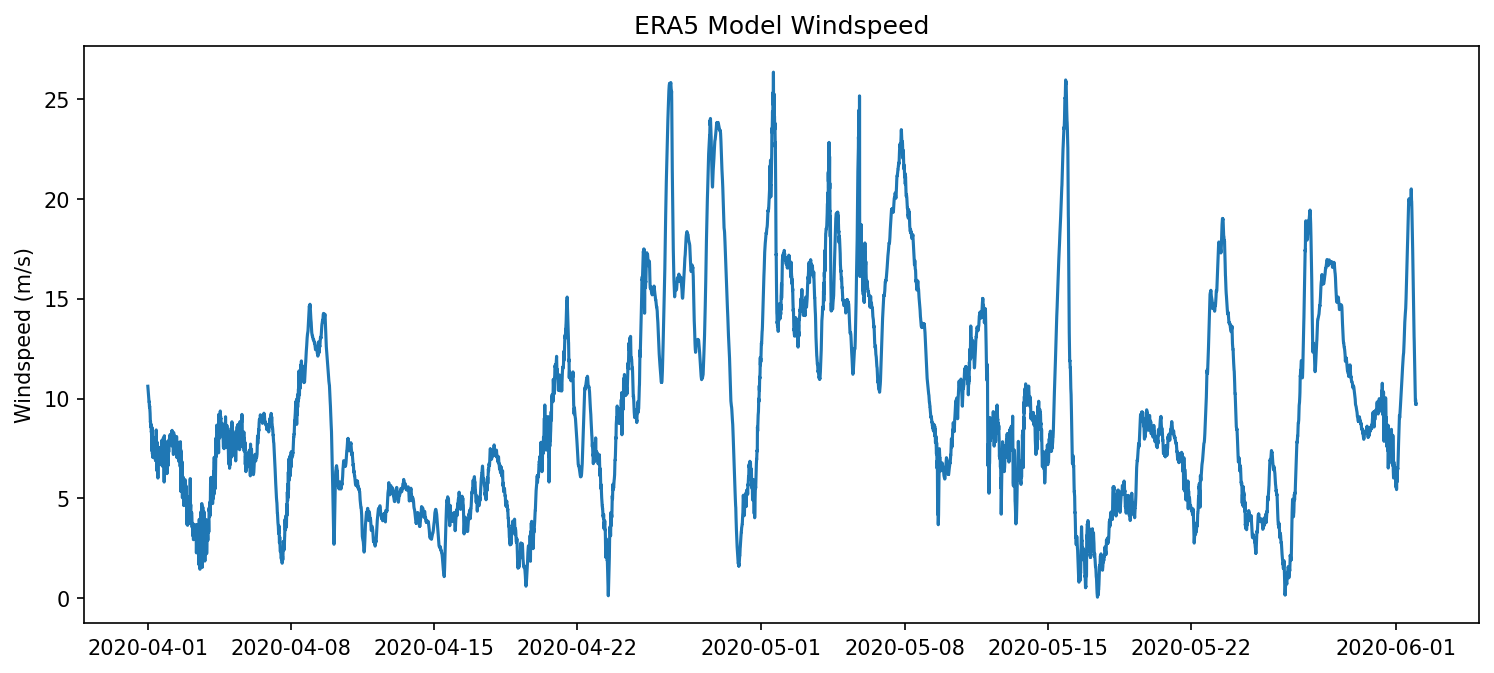

In [22]:
plt.figure(figsize=(12,5), dpi=150)
for col in ws_wd_df.columns:
    if 'ws' in col:
        plt.plot(ws_wd_df.index, ws_wd_df[col])
        break
plt.title('ERA5 Model Windspeed')
plt.ylabel('Windspeed (m/s)')
plt.show()

#### Plot wind direction

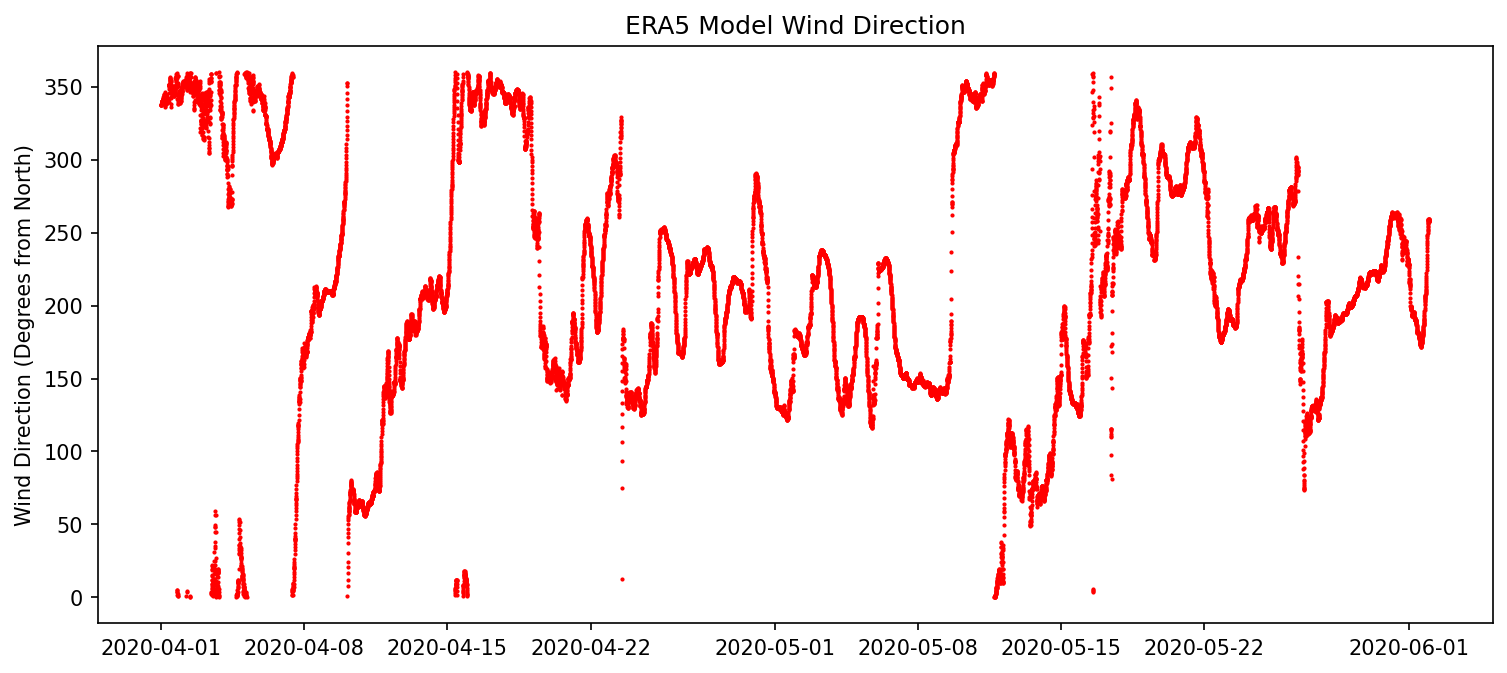

In [23]:
plt.figure(figsize=(12,5), dpi=150)
for col in ws_wd_df.columns:
    if 'wd' in col:
        plt.scatter(ws_wd_df.index, ws_wd_df[col], c='r', s=1)
        break
plt.title('ERA5 Model Wind Direction')
plt.ylabel('Wind Direction (Degrees from North)')
plt.show()

## WTK-LED North America
- **Geographic Resolution:** 4km
- **Temporal Resolution:** 1 hour
- **Time Range:** 2000-2020
- **Heights (m):** 10, 20, 30, 32, 40, 44, 47, 54, 57, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 500, 1000

In [24]:
year = 2020
height = 100
filepath = f'/datasets/WIND/ANL_4km_north_america/north_america_{year}.h5'

### Load the MultiYearWindX File

In [25]:
myr = MultiYearWindX(filepath, hsds=False)

In [26]:
# Get list of available datasets
myr.datasets

['virtual_potential_temperature_40m',
 'windspeed_120m',
 'winddirection_47m',
 'temperature_500m',
 'virtual_potential_temperature_200m',
 'winddirection_44m',
 'windspeed_57m',
 'meta',
 'virtual_potential_temperature_300m',
 'virtual_potential_temperature_100m',
 'winddirection_60m',
 'temperature_40m',
 'coordinates',
 'virtual_potential_temperature_60m',
 'winddirection_57m',
 'windspeed_180m',
 'windspeed_32m',
 'windspeed_500m',
 'windspeed_54m',
 'windspeed_60m',
 'virtual_potential_temperature_1000m',
 'windspeed_1000m',
 'temperature_60m',
 'temperature_200m',
 'pressure_100m',
 'virtual_potential_temperature_2m',
 'winddirection_120m',
 'winddirection_160m',
 'winddirection_300m',
 'winddirection_30m',
 'winddirection_500m',
 'temperature_2m',
 'windspeed_160m',
 'virtual_potential_temperature_80m',
 'winddirection_40m',
 'windspeed_47m',
 'pressure_200m',
 'windspeed_44m',
 'temperature_1000m',
 'windspeed_40m',
 'winddirection_1000m',
 'winddirection_250m',
 'windspeed_100

In [27]:
# Get metadata
myr.meta

,latitude,longitude,timezone,elevation,country,state,county,offshore
gid,,,,,,,,
0,50.982258,-162.061630,-10.0,0,United States,None,None,1
1,51.010925,-162.099060,-10.0,0,United States,None,None,1
2,51.039566,-162.136520,-10.0,0,United States,None,None,1
3,51.068195,-162.174011,-10.0,0,United States,None,None,1
4,51.096817,-162.211578,-10.0,0,United States,None,None,1
...,...,...,...,...,...,...,...,...
2599772,20.954578,-61.076538,-4.0,0,United Kingdom,None,None,1
2599773,20.983326,-61.056641,-4.0,0,United Kingdom,None,None,1
2599774,21.012074,-61.036743,-4.0,0,United Kingdom,None,None,1


In [28]:
# Get dataset attributes
myr.attrs

{'coordinates': {},
 'meta': {},
 'precipitation_0m': {'fill_value': 3.4028235e+38,
  'scale_factor': 1.0,
  'units': 'mm'},
 'pressure_0m': {'fill_value': 65535, 'scale_factor': 0.1, 'units': 'Pa'},
 'pressure_100m': {'fill_value': 65535, 'scale_factor': 0.1, 'units': 'Pa'},
 'pressure_200m': {'fill_value': 65535, 'scale_factor': 0.1, 'units': 'Pa'},
 'pressure_500m': {'fill_value': 65535, 'scale_factor': 0.1, 'units': 'Pa'},
 'temperature_1000m': {'fill_value': 32767,
  'scale_factor': 100.0,
  'units': 'C'},
 'temperature_100m': {'fill_value': 32767,
  'scale_factor': 100.0,
  'units': 'C'},
 'temperature_200m': {'fill_value': 32767,
  'scale_factor': 100.0,
  'units': 'C'},
 'temperature_2m': {'fill_value': 32767, 'scale_factor': 100.0, 'units': 'C'},
 'temperature_300m': {'fill_value': 32767,
  'scale_factor': 100.0,
  'units': 'C'},
 'temperature_30m': {'fill_value': 32767, 'scale_factor': 100.0, 'units': 'C'},
 'temperature_40m': {'fill_value': 32767, 'scale_factor': 100.0, 'uni

In [29]:
# Get dataset lat, lon coordinates
myr.coordinates

array([[  50.982258, -162.06163 ],
       [  51.010925, -162.09906 ],
       [  51.039566, -162.13652 ],
       ...,
       [  21.012074,  -61.036743],
       [  21.040829,  -61.016785],
       [  21.069584,  -60.996857]], dtype=float32)

### Using the same function to get wind speed and direction DataFrame

In [30]:
lat = 50
lon = -135
n_closest_points = 4
start_time = '2020-04-01'
end_time = '2020-06-01'
time_stride = 1

ws_wd_df = get_ws_wd_df(myr, lat, lon, n_closest_points, start_time, end_time, time_stride)

In [31]:
ws_wd_df

,ws211377,ws211376,ws210618,ws211378,wd211377,wd211376,wd210618,wd211378
2020-04-01 00:00:00+00:00,15.390000,15.620000,18.080000,16.600000,353.549988,349.920013,346.410004,3.300000
2020-04-01 01:00:00+00:00,17.980000,18.379999,18.370001,17.459999,357.070007,357.230011,357.470001,357.369995
2020-04-01 02:00:00+00:00,17.330000,17.040001,16.820000,17.309999,1.160000,0.370000,359.829987,1.700000
2020-04-01 03:00:00+00:00,14.190000,14.070000,14.810000,15.290000,13.350000,13.310000,12.180000,10.170000
2020-04-01 04:00:00+00:00,17.590000,17.780001,17.490000,17.080000,0.220000,359.519989,359.450012,2.760000
...,...,...,...,...,...,...,...,...
2020-06-01 19:00:00+00:00,16.400000,16.320000,16.379999,16.490000,176.970001,177.020004,177.710007,176.869995
2020-06-01 20:00:00+00:00,17.040001,17.190001,17.150000,17.030001,179.020004,179.089996,178.869995,178.839996
2020-06-01 21:00:00+00:00,16.570000,16.459999,16.240000,16.870001,184.080002,183.429993,184.770004,184.089996
2020-06-01 22:00:00+00:00,16.719999,16.750000,16.770000,16.459999,192.559998,192.179993,193.580002,192.869995


### Plot Wind Speed and Direction
**Note:** The wind speed and direction should be very similar for all points. The wind direction can shift from 360 to 0, which makes it look discontinuous.

#### Plot wind speed

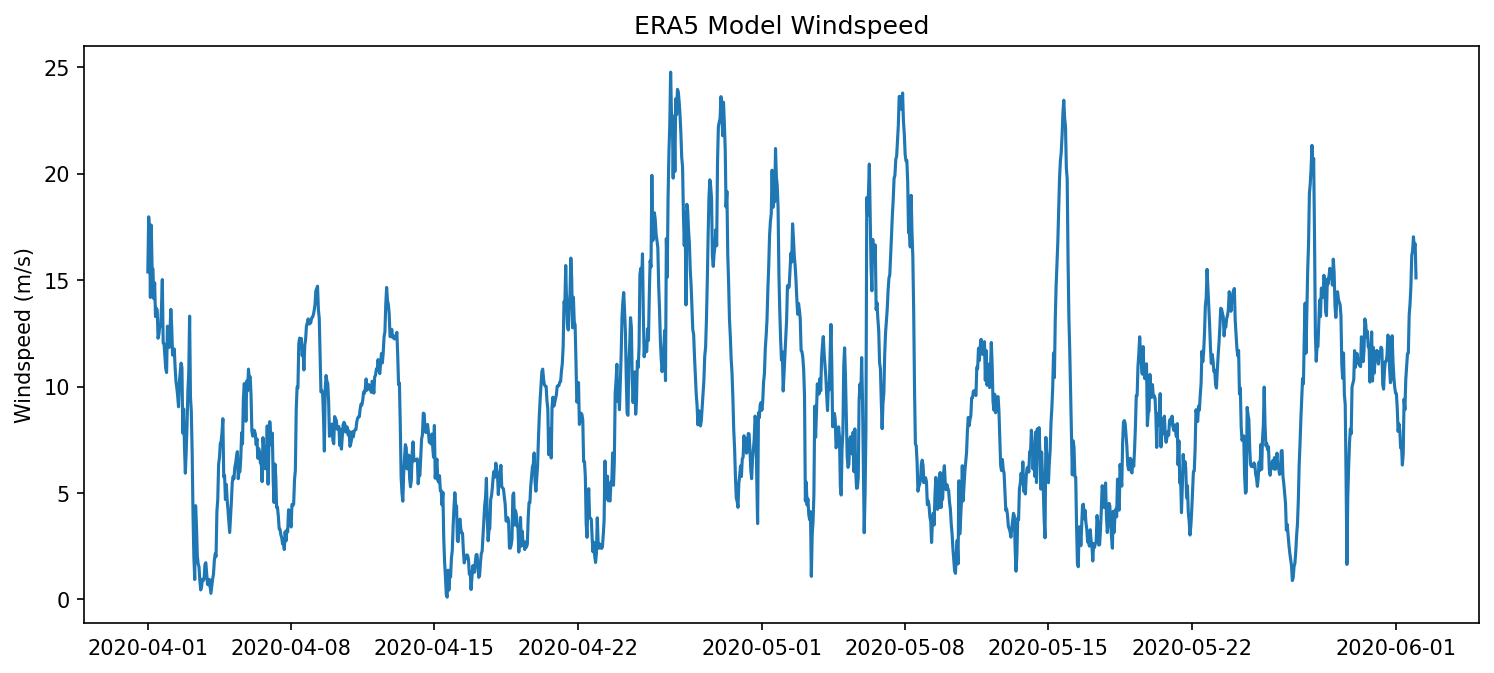

In [32]:
plt.figure(figsize=(12,5), dpi=150)
for col in ws_wd_df.columns:
    if 'ws' in col:
        plt.plot(ws_wd_df.index, ws_wd_df[col])
        break
plt.title('ERA5 Model Windspeed')
plt.ylabel('Windspeed (m/s)')
plt.show()

#### Plot wind direction
**Note:** This is hourly data (compared to 5-minute data above), so the plot is more sparse.

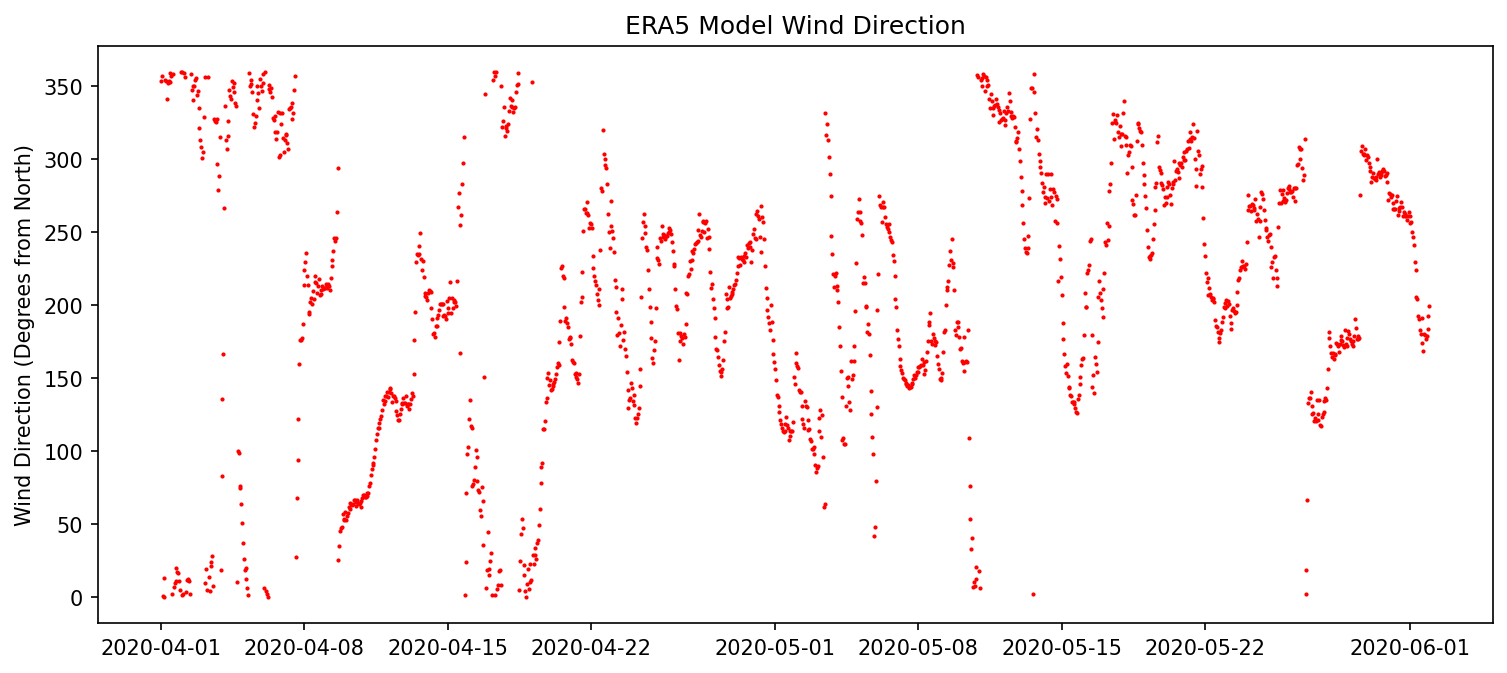

In [33]:
plt.figure(figsize=(12,5), dpi=150)
for col in ws_wd_df.columns:
    if 'wd' in col:
        plt.scatter(ws_wd_df.index, ws_wd_df[col], c='r', s=1)
        break
plt.title('ERA5 Model Wind Direction')
plt.ylabel('Wind Direction (Degrees from North)')
plt.show()

## Comments and Questions:

With any inquiries regarding the code in this notebook, reach out to:

Kevin Menear <kevin.menear@nrel.gov> and Dmitry Duplyakin <dmitry.duplyakin@nrel.gov>